<a href="https://colab.research.google.com/github/LuizFelipeLemon/Self-modeling_Manipulator/blob/main/rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulação de Manipulador Auto-modelável

**Author:** [Luiz Felipe Santana de Araujo Souza](https://github.com/LuizFelipeLemon)<br>
**Orientador:** [Prof. Dr. Orivaldo Vieira de Santana Jr](https://pessoal.ect.ufrn.br/~orivaldo/wordpress/)<br>
**Date created:** 14/04/21<br>
**Description:** Algoritmo de machine learning que permite um Panda Arm aprender um modelo próprio de sua estrutura.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler
import math
import datetime
import pandas as pd
from io import StringIO
import time

np.set_printoptions(threshold=np.inf)


# Coleta de Dados

O projeto aqui apresentado é composto por um algoritmo de aprendizagem profunda e um manipulador robótico em ambiente simulado. Inicialmente é necessária uma coleta de dados de movimentações realizadas pelo manipulador ([link](https://app.theconstructsim.com/#/)), fornecendo informações para o algoritmo realizar seu treinamento.  

É necessário cricar uma conta para que se possa encontrar o repositório deste projeto. Com a conta criada vá em `Public Rosjects` e busque por `Simulação de Manipulador Auto-modelável` e clone o respositório mostrado abaixo. 


> > > > ![img0001.png](https://raw.githubusercontent.com/LuizFelipeLemon/Self-modeling_Manipulator/main/img0001.png)







Siga as instruções o tópico Collect_data que, ao final, um csv com os pontos coletados será retornado. 

Os arquivos utilizados durante o desenvolvimento do trabalho também estão disponíveis no [repositório do projeto].(https://github.com/LuizFelipeLemon/Self-modeling_Manipulator)


In [ ]:
# Cria os normalizadores de dados
scaler = MinMaxScaler(feature_range=(-1,1))
scaler_input = MinMaxScaler(feature_range=(-1,1))
scaler_output = MinMaxScaler(feature_range=(-1,1))
TRANING_RATIO = .8
BUFFER_LEN = 14
#SEQUENCE_LEN = 5


In [ ]:
def load_data():

  #load the dataset and scales it
  dataset = pd.read_csv('full.CSV') # Dataset Completo

  input_data = dataset.loc[:, ["joint1_pos","joint2_pos","joint3_pos","joint4_pos","joint5_pos","joint6_pos","joint7_pos", "x", "y", "z", "joint1_action","joint2_action","joint3_action","joint4_action","joint5_action","joint6_action","joint7_action"]]
  next_states = dataset.loc[:, ["nxt_joint1_pos","nxt_joint2_pos","nxt_joint3_pos","nxt_joint4_pos","nxt_joint5_pos","nxt_joint6_pos","nxt_joint7_pos", "nxt_x", "nxt_y", "nxt_z"]]
    
  raw_data = np.append(input_data.to_numpy(),next_states.to_numpy(),axis=1)

  input_scaled  = scaler_input.fit_transform(input_data) 
  next_states_scaled = scaler_output.fit_transform(next_states)

  data = np.append(input_scaled,next_states_scaled,axis=1)

  # Create the Training dataset
  training_data_len = math.ceil(len(dataset) * TRANING_RATIO)
  test_data_len = len(dataset) - training_data_len

  train_data = data[0:training_data_len,:] 
  test_data  = data[training_data_len:, :]

  x_train = []
  y_train = []
  x_test  = []
  y_test  = []

  print(input_scaled.shape)
  print(next_states_scaled.shape)

  # Cria Batches de dados, seguindo a estrutura descrita no TCC
  for i in range(BUFFER_LEN,len(train_data)):
    x_train.append(train_data[i-BUFFER_LEN:i,0:input_scaled.shape[1]])
    temp = []
    for j in range(i-4,i+1):
      temp.append(train_data[j, input_scaled.shape[1]:])
    y_train.append(temp)
    
  
  for i in range(BUFFER_LEN,test_data_len):
    x_test.append(test_data[i-BUFFER_LEN:i,0:input_scaled.shape[1]]) 
    temp = []
    for j in range(i-4,i+1):
      temp.append(test_data[j, input_scaled.shape[1]:])
    y_test.append(temp)

  x_train, y_train = np.asarray(x_train), np.asarray(y_train) 
  x_test, y_test = np.asarray(x_test), np.asarray(y_test)
  
  return (x_train, y_train) , (x_test, y_test)
  



In [ ]:
# Cria os conjuntos de treinamento e Validação
(x_train , y_train) , (x_test , y_test) = load_data()

# Treinamento

In [ ]:
l_s = 5 # Variável que define o tamanho do conjunto de estados que serão estimados

#Define a estrutura da rede neural
generator = keras.Sequential(
    [
     
        keras.Input(shape=(x_train.shape[1] - (l_s - 1), x_train.shape[2])),
        layers.BatchNormalization(),
        layers.GRU(1024, return_sequences=True, return_state=False, unroll=True, dtype=tf.float32),
        layers.Permute((2,1)),
        layers.Conv1D(64, 3),
        layers.Conv1D(32, 1),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.Dropout(0.5),
        layers.Activation('relu'),
        layers.BatchNormalization(),
        layers.Dense(256),
        layers.Dropout(0.5),
        layers.Activation('relu'),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.Dropout(0.5),
        layers.Activation('relu'),
        layers.BatchNormalization(),
        layers.Dense(256),
        layers.Dropout(0.5),
        layers.Activation('relu'),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.Dropout(0.5),
        layers.Activation('relu'),
        layers.BatchNormalization(),
        layers.Dense(y_train.shape[2] ,activation='tanh'),
    ],
    name="generator",
)

generator.summary()

In [ ]:
# Definição da função de perda personalizada
def my_loss_fn(y_true, y_pred):
    x = tf.cast(y_true[4:],tf.float32)
    y = tf.cast(y_pred[4:],tf.float32)
    euclidean_norm = tf.norm(tf.math.subtract(x, y))
    return euclidean_norm

In [ ]:
# Instacia otimizadores
g_optimizer = keras.optimizers.Adam(learning_rate=0.00005)

# Instacia a função de perda
loss_fn = my_loss_fn

# Prepara as metricas.
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

state_dim = 10
action_dim = 7

# Define a função que realizará o treinamento do modelo
@tf.function
def train_step(x, y):

    entrada = []
    saida = []

    x = tf.cast(x,tf.float32)

    states, actions  = tf.split(x, [state_dim, action_dim], 2)
    states_buffer = states[:,0:10,:]
    actions_buffer = actions[:,0:10,:]                                      

    tempx_0 = tf.concat([states[:,0:10,:], actions[:,0:10,:]], 2)

    entrada.append(tempx_0)

    tempy_0 = y[:, 0, :]

    with tf.GradientTape() as tape:
        y_hat = generator(tempx_0)
        g_loss = loss_fn(tf.squeeze(tempy_0), y_hat)
        saida.append(y_hat)

        for i in range(l_s):
          # pop buffer
          states_buffer = states_buffer[:, 1:, :] 
          # Insere a estimativa
          states_buffer = tf.concat([states_buffer, tf.expand_dims(y_hat, axis=1)], 1) 
          # Constrói a entrada
          tempx = tf.concat([states_buffer, actions[:,i+1 : 11+i,:]], 2) 

          tempy = y[:, i+1, :] # mount goal

          y_hat = generator(tempx)
          g_loss += loss_fn(tempy, y_hat)
          saida.append(y_hat)

          # Update training metric.
          train_acc_metric.update_state(tempy, y_hat)


    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

     


    return  g_loss, saida

In [ ]:
# Define a função de validação
@tf.function
def test_step(x, y):
  
    entrada = []
    saida = []

    x = tf.cast(x,tf.float32)

    states, actions  = tf.split(x, [state_dim, action_dim], 2)
    states_buffer = states[:,0:10,:]
    actions_buffer = actions[:,0:10,:]                                      

    tempx_0 = tf.concat([states[:,0:10,:], actions[:,0:10,:]], 2)

    entrada.append(tempx_0)

    tempy_0 = y[:, 0, :]


    y_hat = generator(tempx_0, training=False)
    g_loss = loss_fn(tf.squeeze(tempy_0), y_hat)
    saida.append(y_hat)
    val_acc_metric.update_state(tf.squeeze(tempy_0), y_hat) 

    for i in range(l_s):
      # pop buffer
          states_buffer = states_buffer[:, 1:, :] 
          # Insere a estimativa
          states_buffer = tf.concat([states_buffer, tf.expand_dims(y_hat, axis=1)], 1) 
          # Constrói a entrada
          tempx = tf.concat([states_buffer, actions[:,i+1 : 11+i,:]], 2) 

      tempy = y[:, i+1, :] # mount goal
      saida.append(tempy)

      y_hat = generator(tempx, training=False)
      g_loss += loss_fn(tempy, y_hat)
      saida.append(y_hat)
      val_acc_metric.update_state(tempy, y_hat)

    return  g_loss, saida

In [ ]:
# Função experimental
@tf.function
def test_step2(x, y):
  
    entrada = []
    saida = []

    x = tf.cast(x,tf.float32)

    states, actions  = tf.split(x, [state_dim, action_dim], 2)
    states_buffer = states[:,0:10,:]
    actions_buffer = actions[:,0:10,:]                                      
    #print("Separei em states e actions: ", states.shape, actions.shape)

    tempx_0 = tf.concat([states[:,0:10,:], actions[:,0:10,:]], 2)
    #print("Primeira entrada: ", tempx_0.shape)

    entrada.append(tempx_0)

    tempy_0 = y[:, 0, :]
    #print("Primeira saída esperada: ", tempy_0.shape)  

    #saida.append(tf.squeeze(tempy_0))

    y_hat = generator(tempx_0, training=False)
    g_loss = loss_fn(tempy_0, y_hat)
    saida.append(y_hat)

    for i in range(l_s):
      states_buffer = states_buffer[:, 1:, :] # pop
      states_buffer = tf.concat([states_buffer, tf.expand_dims(y_hat, axis=1)], 1) # Insert prediction
      tempx = tf.concat([states_buffer, actions[:,i+1 : 11+i,:]], 2) # mount input

      tempy = y[:, i+1, :] # mount goal
      #saida.append(tempy)

      y_hat = generator(tempx, training=False)
      g_loss += loss_fn(tempy, y_hat)
      saida.append(y_hat)
      val_acc_metric.update_state(tempy, y_hat)

    return  g_loss, saida

In [ ]:
import os

# Prepare the dataset. We use both the training
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test))
val_dataset = val_dataset.batch(batch_size)


In [ ]:
epochs = 10 
save_dir = "./"
MSE_list = []
val_MSE_list = []

for epoch in range(epochs):
    print("\nPrimeira Época", epoch)
    start_time = time.time()
    for step, input in enumerate(train_dataset):
        g_loss, generated_predictions = train_step(input[0], input[1])

        # Logging.
        if step % 500 == 0:
            # Print metrics
            print("Perda por passo: %d: %.2f" % (step, g_loss))
        
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("MSE de treinamento  por época: %.4f" % (float(train_acc),))
    MSE_list.append(float(train_acc))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    print("empo por época: %.2fs" % (time.time() - start_time))

    for step, input in enumerate(val_dataset):
      g_loss, estimate = test_step(input[0], input[1])

    val_acc = val_acc_metric.result()
    val_MSE_list.append(float(val_acc))
    val_acc_metric.reset_states()
    print("Erro de validação (MSE): %.4f" % (float(val_acc),))



Start epoch 0
adversarial loss at step 0: 39.78
adversarial loss at step 500: 27.23
Training MSE over epoch: 0.1583
Time per epoch: 42.24s
Validation MSE: 0.1170

Start epoch 1
adversarial loss at step 0: 25.63
adversarial loss at step 500: 26.05
Training MSE over epoch: 0.1213
Time per epoch: 29.83s
Validation MSE: 0.1109

Start epoch 2
adversarial loss at step 0: 24.41
adversarial loss at step 500: 25.79
Training MSE over epoch: 0.1163
Time per epoch: 29.82s
Validation MSE: 0.1092

Start epoch 3
adversarial loss at step 0: 23.82
adversarial loss at step 500: 25.54
Training MSE over epoch: 0.1132
Time per epoch: 29.81s
Validation MSE: 0.1082

Start epoch 4
adversarial loss at step 0: 23.50
adversarial loss at step 500: 25.12
Training MSE over epoch: 0.1107
Time per epoch: 29.78s
Validation MSE: 0.1081

Start epoch 5
adversarial loss at step 0: 23.19
adversarial loss at step 500: 24.79
Training MSE over epoch: 0.1085
Time per epoch: 29.79s
Validation MSE: 0.1083

Start epoch 6
adversa

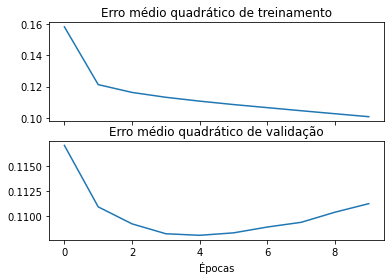

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0, epochs)

fig, (ax1, ax2) = plt.subplots(2)
ax1.set(title='Erro médio quadrático de treinamento')
ax1.label_outer()
ax2.set(xlabel='Épocas',
       title='Erro médio quadrático de validação')
ax1.plot(t, MSE_list)
ax2.plot(t, val_MSE_list)

fig.savefig("/content/drive/MyDrive/TCC/hum.png")

In [ ]:
val_MSE_list.index(min(val_MSE_list))
print(val_MSE_list[3:10])

[0.10822498798370361, 0.10806987434625626, 0.1083129271864891, 0.10889571905136108, 0.10936591029167175, 0.11037523299455643, 0.11122942715883255]


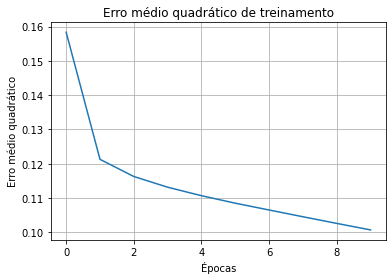

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0, epochs)


fig, ax = plt.subplots()
ax.plot(t, MSE_list)

ax.set(xlabel='Épocas', ylabel='Erro médio quadrático',
       title='Erro médio quadrático de treinamento')
ax.grid()

fig.savefig("/content/drive/MyDrive/TCC/full_dataset.png")
plt.show()

In [ ]:
# Run a validation loop
x = []
y = []
est = []

for step, input in enumerate(val_dataset):
    g_loss, estimate = test_step(input[0], input[1])

val_acc = val_acc_metric.result()
val_acc_metric.reset_states()
print("Erro de validação (MSE): %.4f" % (float(val_acc),))

Validation MSE: 0.1112
Time taken: 35.01s


# Validação

Nesta etapa, são remontados o cojunto de validação junto com as estimativas, realizando a desnormalização dos dados para que estes possam ser inseridos na simulação.

Os arquivos resultantes devem ser baixados e inseridos no repositório no The Construct

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test , y_test))
x = []
y = []
est = []

for step, input in enumerate(test_dataset):
    x_t = tf.expand_dims(input[0], axis=0)
    y_t = tf.expand_dims(input[1], axis=0)

    g_loss, estimate = test_step2(x_t,y_t )
    x.append(input[0])
    y.append(input[1])
    est.append(estimate)
    
x_np = np.array(x)
y_np = np.array(y)
est_np = np.squeeze(np.array(est))


(5999, 14, 17)
(5999, 5, 10)
(5999, 5, 10)


In [ ]:
a  = scaler_input.inverse_transform(x_np.reshape(x_test.shape[0]*14,x_test.shape[2])) 
b = scaler_output.inverse_transform(y_np.reshape(y_test.shape[0]*5,y_test.shape[2]))
c = scaler_output.inverse_transform(est_np.reshape(y_test.shape[0]*5, y_test.shape[2]))

In [ ]:


x_np2 = a.reshape(x_test.shape[0], 14, 17)
y_np2 = b.reshape(y_test.shape[0], 5, 10)
est_np2 = c.reshape(y_test.shape[0], 5, 10)

np.save('x.npy', x_np2)
np.save('y.npy', y_np2)
np.save('est.npy', est_np2)

(5999, 14, 17)
(5999, 5, 10)
(5999, 5, 10)


# Exportar rede


In [ ]:
#Exportação
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

#serialize model to JSON #
model_json = generator.to_json()
with open("/content/drive/MyDrive/TCC/full5pochs_30K_loss_positional.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
generator.save_weights("/content/drive/MyDrive/TCC/full5pochs_30K_loss_positional.h5")
print("Saved model to disk")
 
# later...


Saved model to disk


In [ ]:
#Importação
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# load json and create model
json_file = open('/content/drive/MyDrive/TCC/full5pochs_30K_loss_positional.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
generator = model_from_json(loaded_model_json)
# load weights into new model
generator.load_weights("/content/drive/MyDrive/TCC/full5epochs_30K_loss_positional.h5")
print("Loaded model from disk")
 
